In [8]:
#################################################### zadanie 2 ########################################################

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF
from pyspark.sql.functions import rand

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.sql.functions import col, when

from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
import pyspark.sql.functions as F

# 1. Inicjalizacja SparkSession
spark = SparkSession.builder \
    .appName("SMS Preprocessing") \
    .getOrCreate()

# 2. Wczytanie danych
df = spark.read.csv("sms.csv", header=False, sep=";", inferSchema=True) \
    .toDF('id', 'text', 'label')

# 3. Czyszczenie danych: usunięcie interpunkcji i cyfr
df_clean = df.withColumn('clean_text', regexp_replace(col('text'), '[^\sa-zA-Z]', ''))

# 4. Wczytanie stopwords.txt
stopwords_path = "stopwords.txt"
with open(stopwords_path, "r", encoding="utf-8") as f:
    extra_stopwords = [line.strip() for line in f if line.strip()]

# 5. Tokenizacja tekstu
tokenizer = Tokenizer(inputCol='clean_text', outputCol='words')
df_tokenized = tokenizer.transform(df_clean)

# 6. Usuwanie stopwords
remover = StopWordsRemover(inputCol='words', outputCol='filtered_words', stopWords=extra_stopwords)
df_filtered = remover.transform(df_tokenized)

# 7. Zastosowanie HashingTF
hashing_tf = HashingTF(inputCol='filtered_words', outputCol='features', numFeatures=10000)
df_featurized = hashing_tf.transform(df_filtered)

# 8. Podział na zbiór treningowy i testowy (z zachowaniem rozkładu klas)

# Najpierw przetasuj dane
df_featurized = df_featurized.orderBy(rand())

# Następnie osobno podziel klasy 0 i 1
df_class_0 = df_featurized.filter(col('label') == 0)
df_class_1 = df_featurized.filter(col('label') == 1)

train_0, test_0 = df_class_0.randomSplit([0.7, 0.3], seed=42)
train_1, test_1 = df_class_1.randomSplit([0.7, 0.3], seed=42)

# Połącz treningowe i testowe zbiory
train_data = train_0.union(train_1)
test_data = test_0.union(test_1)

#print("\nPierwsze 5 wierszy i pierwsze 5 kolumn zbioru treningowego:")
#train_data.select('id', 'text', 'clean_text', 'filtered_words', 'features').show(5, truncate=False)

#################################################### zadanie 3 ########################################################

# 1. Utworzenie modelu regresji logistycznej
lr = LogisticRegression(featuresCol='features', labelCol='label')

# 2. Trenowanie modelu na danych treningowych
lr_model = lr.fit(train_data)

# 3. Predykcje na danych testowych
predictions = lr_model.transform(test_data)

# 4. Ocena modelu
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

#print(f"\nWartość AUC na zbiorze testowym: {auc:.4f}")

#################################################### zadanie 4 ########################################################

# 1. Zamiana predykcji prawdopodobieństwa na klasy 0/1
predictions = predictions.withColumn("prediction_label", when(col("prediction") >= 0.5, 1).otherwise(0))

# 2. Obliczenie elementów macierzy pomyłek
TP = predictions.filter((col("label") == 1) & (col("prediction_label") == 1)).count()
TN = predictions.filter((col("label") == 0) & (col("prediction_label") == 0)).count()
FP = predictions.filter((col("label") == 0) & (col("prediction_label") == 1)).count()
FN = predictions.filter((col("label") == 1) & (col("prediction_label") == 0)).count()

# 3. Wyświetlenie macierzy pomyłek
print("\nMacierz pomyłek:")
print(f"TP (True Positive) : {TP}")
print(f"FN (False Negative): {FN}")
print(f"FP (False Positive): {FP}")
print(f"TN (True Negative) : {TN}")

# 4. Obliczenie metryk
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

print(f"\nAccuracy    : {accuracy:.4f}")
print(f"Sensitivity : {sensitivity:.4f}")
print(f"Specificity : {specificity:.4f}")

#################################################### zadanie 5 ########################################################

# Funkcje UDF do wyciągania wartości z wektora probability
def extract_prob_0(probability):
    return float(probability[0])

def extract_prob_1(probability):
    return float(probability[1])

# 1. Rejestracja funkcji jako UDF
extract_prob_0_udf = udf(extract_prob_0, DoubleType())
extract_prob_1_udf = udf(extract_prob_1, DoubleType())

# 2. Dodanie kolumn z prawdopodobieństwem klas
predictions = predictions.withColumn("prob_0", extract_prob_0_udf(col("probability")))
predictions = predictions.withColumn("prob_1", extract_prob_1_udf(col("probability")))

# 3. Szukanie tekstow
max_prob_0 = predictions.orderBy(col("prob_0").desc()).select("text", "prob_0").first()
max_prob_1 = predictions.orderBy(col("prob_1").desc()).select("text", "prob_1").first()

print(f"\nTekst o najwyższym p(klasa=0):\n\"{max_prob_0['text']}\"\nPrawdopodobieństwo: {max_prob_0['prob_0']:.4f}")
print(f"\nTekst o najwyższym p(klasa=1):\n\"{max_prob_1['text']}\"\nPrawdopodobieństwo: {max_prob_1['prob_1']:.4f}")

# 4. Predykcja dla nowego tekstu

# Przygotuj tekst
new_text = "How many machine learning specialists does it take to change a light bulb? - Just one, but they require a million light bulbs to train properly."

# a) Stwórz DataFrame z nowym tekstem
new_text_df = spark.createDataFrame([(0, new_text)], ["id", "text"])

# b) Oczyść tekst z interpunkcji i cyfr
new_text_clean = new_text_df.withColumn('clean_text', regexp_replace(col('text'), '[^\sa-zA-Z]', ''))

# c) Tokenizacja
tokenizer = Tokenizer(inputCol='clean_text', outputCol='words')
new_text_tokenized = tokenizer.transform(new_text_clean)

# d) Usunięcie stopwords
remover = StopWordsRemover(inputCol='words', outputCol='filtered_words', stopWords=extra_stopwords)
new_text_filtered = remover.transform(new_text_tokenized)

# e) HashingTF
hashing_tf = HashingTF(inputCol='filtered_words', outputCol='features', numFeatures=10000)
new_text_features = hashing_tf.transform(new_text_filtered)

# f) Predykcja
new_text_prediction = lr_model.transform(new_text_features)

# g) Wyciągnięcie prawdopodobieństwa klasy 1 za pomocą UDF
new_text_prediction = new_text_prediction.withColumn("prob_1", extract_prob_1_udf(col("probability")))
new_text_prob_1 = new_text_prediction.select("prob_1").first()

print("\nPrawdopodobieństwo klasy 1 (spam) dla nowego tekstu:")
print(f"{new_text_prob_1['prob_1']:.4f}")

#Zatrzymanie SparkSession
spark.stop()


Macierz pomyłek:
TP (True Positive) : 175
FN (False Negative): 20
FP (False Positive): 28
TN (True Negative) : 1353

Accuracy    : 0.9695
Sensitivity : 0.8974
Specificity : 0.9797



Tekst o najwyższym p(klasa=0):
"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."
Prawdopodobieństwo: 1.0000

Tekst o najwyższym p(klasa=1):
"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"
Prawdopodobieństwo: 1.0000



Prawdopodobieństwo klasy 1 (spam) dla nowego tekstu:
0.0000


Pierwsze 10 wierszy:
+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|id |text                                                                                                                                                       |label|
+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|1  |Sorry, I'll call later in meeting                                                                                                                          |0    |
|2  |Dont worry. I guess he's busy.                                                                                                                             |0    |
|3  |Call FREEPHONE 0800 542 0578 now!                                                                                                     

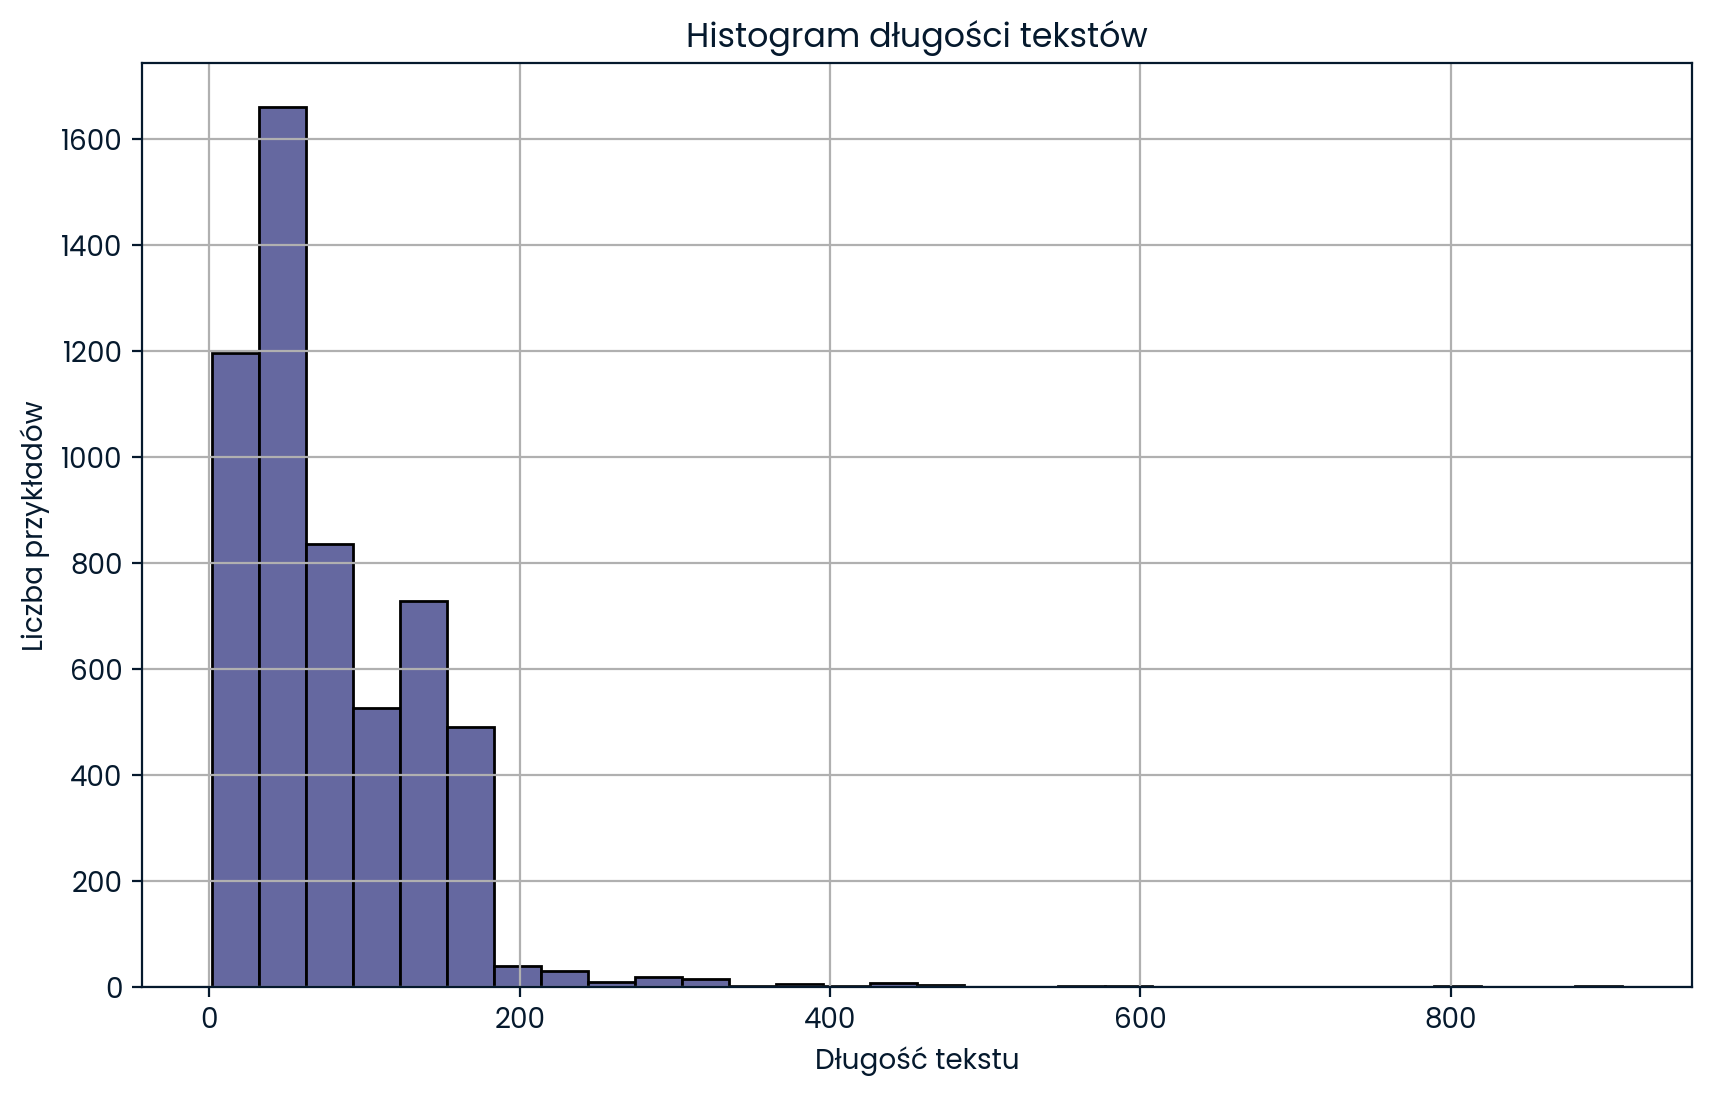

In [9]:
################################################# zadanie 1 ###########################################################
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, count, when
import matplotlib.pyplot as plt

# 1. Inicjalizacja SparkSession
spark = SparkSession.builder \
    .appName("CSV Analysis") \
    .getOrCreate()

# 2. Wczytanie pliku CSV
df = spark.read.csv('sms.csv', header=False, sep=';', inferSchema=True) \
    .toDF('id', 'text', 'label')

# 3. Podgląd 10 pierwszych wierszy
print("Pierwsze 10 wierszy:")
df.show(10, truncate=False)

# 4. Statystyki

# Liczba wszystkich wierszy
total_rows = df.count()
print(f"\nLiczba wszystkich wierszy: {total_rows}")

# Procent przykładów z klas 0 i 1
label_counts = df.groupBy("label").count().toPandas()
label_counts["percent"] = (label_counts["count"] / total_rows) * 100
print("\nProcent przykładów z klas 0 i 1:")
print(label_counts)

# Dodanie kolumny z długością tekstu
df_with_length = df.withColumn("text_length", length(col("text")))

# Długość najkrótszego i najdłuższego tekstu
min_length = df_with_length.agg({"text_length": "min"}).first()[0]
max_length = df_with_length.agg({"text_length": "max"}).first()[0]
print(f"\nNajkrótszy tekst ma {min_length} znaków.")
print(f"Najdłuższy tekst ma {max_length} znaków.")

# Średnia długość tekstu
avg_length = df_with_length.agg({"text_length": "avg"}).first()[0]
print(f"Średnia długość tekstu: {avg_length:.2f} znaków.")

# 5. Rysowanie histogramu długości tekstów

# Pobranie długości do Pandas (dla wykresu)
lengths = df_with_length.select("text_length").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(lengths["text_length"], bins=30, edgecolor='black')
plt.title("Histogram długości tekstów")
plt.xlabel("Długość tekstu")
plt.ylabel("Liczba przykładów")
plt.grid(True)
plt.show()

# 6. Zatrzymanie SparkSession
spark.stop()
